In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from model import AtlasResNet34, AtlasResNet18, predict_proba
from model4 import AtlasSEResnet50

from utils import load_checkpoint
from gpu_utils import set_n_get_device
from metrics import macro_f1, macro_f1_numpy
from dataset import train_test_split, AtlasDataSet

%matplotlib inline

In [2]:
device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:2")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
#device = 'cpu'
multi_gpu = [0, 2, 3]#[1, 2]#None, 0, 1, 2, 3

# for blending model's selecting best threshold, use seed 2345 (it has best single model LB score)
SEED = 2345##2345 #5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
BATCH_SIZE = 32
NUM_WORKERS = 20
IMG_SIZE = 512

## select best threshold for each class on validset

In [3]:
# load validset
fname_train, fname_valid = train_test_split(SEED, debug)
val_ds = AtlasDataSet(fname_valid, mode='train', augmentation=False, IMG_SIZE=IMG_SIZE)
val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )
#TTA
val_ds_flip = AtlasDataSet(fname_valid, mode='train', augmentation=False, IMG_SIZE=IMG_SIZE, flip=True)
val_dl_flip = DataLoader(
        val_ds_flip,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )

total trainset:  53527
IMG_SIZE:  512
IMG_SIZE:  512


In [4]:
# y should be makeup
y_valid = []
for i, (input_data, truth) in enumerate(val_dl):
    #if i==10:
    #    break
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(5142, 28)

In [5]:
# load trained model
net = AtlasResNet34(debug=False).cuda(device=device)
#net = AtlasResNet18(debug=False).cuda(device=device)
#net = AtlasSEResnet50(debug=False).cuda(device=device)
checkpoint_path = 'checkpoint/1222_v2_seed3456/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

raw_weight size:  torch.Size([64, 3, 7, 7])
new_weight size:  torch.Size([64, 4, 7, 7])


In [11]:
#net = nn.DataParallel(net, device_ids=multi_gpu)

In [6]:
%%time
# predict_proba
net.set_mode('valid')#.module
preds_valid = (predict_proba(net, val_dl, device, multi_gpu=False) + 
               predict_proba(net, val_dl_flip, device, multi_gpu=False)) / 2

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 1min 55s, sys: 35 s, total: 2min 30s
Wall time: 2min 41s


In [5]:
# only for ensemble N models, to calculate threshold on validset

# load trained model resnet34
net = AtlasResNet34(debug=False).cuda(device=device)

checkpoint_path = 'checkpoint/1222_v2_seed1234/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)
net.set_mode('valid')
preds_valid0 = (predict_proba(net, val_dl, device, multi_gpu=False) + 
               predict_proba(net, val_dl_flip, device, multi_gpu=False)) / 2
print('model 0 done')

checkpoint_path = 'checkpoint/1222_v2_seed2345/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)
net.set_mode('valid')
preds_valid1 = (predict_proba(net, val_dl, device, multi_gpu=False) + 
               predict_proba(net, val_dl_flip, device, multi_gpu=False)) / 2
print('model 1 done')

checkpoint_path = 'checkpoint/1222_v2_seed3456/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)
net.set_mode('valid')
preds_valid2 = (predict_proba(net, val_dl, device, multi_gpu=False) + 
               predict_proba(net, val_dl_flip, device, multi_gpu=False)) / 2
print('model 2 done')

preds_valid = (preds_valid0 + preds_valid1 + preds_valid2) / 3

raw_weight size:  torch.Size([64, 3, 7, 7])
new_weight size:  torch.Size([64, 4, 7, 7])


/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


model 0 done
model 1 done
model 2 done


Best threshold:  [ 0.09045226  0.11055276  0.31155779 -0.11055276 -0.47236181 -0.05025126
 -0.75376884 -0.03015075 -0.47236181 -0.87437186 -1.03517588 -0.17085427
  0.05025126 -0.15075377 -0.19095477 -1.03517588 -0.21105528 -0.29145729
  0.25125628 -0.35175879 -0.23115578  0.31155779 -0.59296482 -0.33165829
  0.53266332 -0.53266332  0.19095477 -1.69849246]
CPU times: user 1min 16s, sys: 320 ms, total: 1min 16s
Wall time: 1min 31s


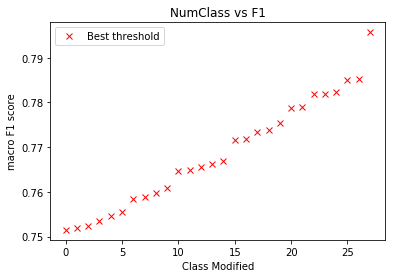

In [84]:
%%time
#class-specific-threshold(i.e. 28 thresholds for each class)
thresholds_candidates = np.linspace(-2, 2, 200)#np.linspace(0.01, 0.99, 50)
#print('threshold candidate: ', thresholds_candidates)

thresholds = np.array([0.5]*28)

f1_score_best_list = []

for c in range(28):
    
    f1_scores = []
    for i in thresholds_candidates:
        thresholds[c] = i

        f1_score = macro_f1_numpy(preds_valid, y_valid, threshold=thresholds)
        f1_scores.append(f1_score)

    # best threshold for this class
    threshold_best_index = np.argmax(f1_scores)
    f1_score_best = f1_scores[threshold_best_index]
    threshold_best = thresholds_candidates[threshold_best_index]
    ## add f1_score_best to history, and set threshold best for this class
    f1_score_best_list.append(f1_score_best)
    thresholds[c] = threshold_best

print('Best threshold: ', thresholds)

plt.plot(range(28), f1_score_best_list, "xr", label="Best threshold")
plt.xlabel("Class Modified")
plt.ylabel("macro F1 score")
plt.title("NumClass vs F1")
plt.legend()

Best threshold:  [-0.11055276 -0.57286432 -0.35175879 -0.27135678 -0.11055276 -0.31155779
 -0.59296482 -0.07035176 -0.15075377 -0.65326633 -0.59296482  0.19095477
 -0.21105528 -0.45226131 -0.47236181 -0.75376884  0.29145729  0.25125628
 -0.01005025 -0.23115578 -0.15075377 -0.05025126 -0.75376884 -0.79396985
  0.29145729 -0.23115578  0.25125628 -0.81407035]
CPU times: user 1min 6s, sys: 32 ms, total: 1min 6s
Wall time: 1min 6s


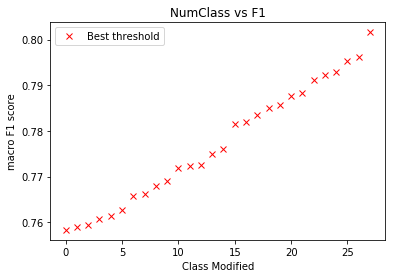

In [7]:
%%time
#class-specific-threshold(i.e. 28 thresholds for each class)
thresholds_candidates = np.linspace(-2, 2, 200)#np.linspace(0.01, 0.99, 50)
#print('threshold candidate: ', thresholds_candidates)

thresholds = np.array([0.5]*28)

f1_score_best_list = []

for c in range(28):
    
    f1_scores = []
    for i in thresholds_candidates:
        thresholds[c] = i

        f1_score = macro_f1_numpy(preds_valid, y_valid, threshold=thresholds)
        f1_scores.append(f1_score)

    # best threshold for this class
    threshold_best_index = np.argmax(f1_scores)
    f1_score_best = f1_scores[threshold_best_index]
    threshold_best = thresholds_candidates[threshold_best_index]
    ## add f1_score_best to history, and set threshold best for this class
    f1_score_best_list.append(f1_score_best)
    thresholds[c] = threshold_best

print('Best threshold: ', thresholds)

plt.plot(range(28), f1_score_best_list, "xr", label="Best threshold")
plt.xlabel("Class Modified")
plt.ylabel("macro F1 score")
plt.title("NumClass vs F1")
plt.legend()

Best threshold:  [-0.07035176 -0.4321608  -0.25125628 -0.3919598  -0.93467337 -0.95477387
 -0.89447236  0.05025126 -1.27638191 -0.91457286 -1.2160804   0.07035176
 -0.3718593  -0.63316583 -0.69346734 -1.07537688  0.13065327 -0.71356784
 -0.49246231 -0.85427136 -0.55276382  0.07035176 -0.67336683 -0.11055276
  0.3919598  -0.35175879 -0.27135678 -1.69849246]


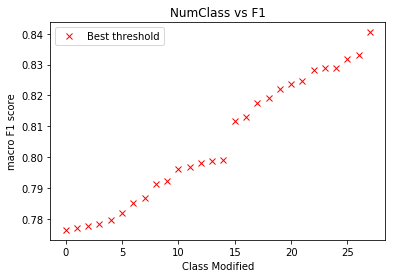

In [12]:
## ensemble models ##

#class-specific-threshold(i.e. 28 thresholds for each class)
thresholds_candidates = np.linspace(-2, 2, 200)#np.linspace(0.01, 0.99, 50)

thresholds = np.array([0.5]*28)

f1_score_best_list = []

for c in range(28):
    
    f1_scores = []
    for i in thresholds_candidates:
        thresholds[c] = i

        f1_score = macro_f1_numpy(preds_valid, y_valid, threshold=thresholds)
        f1_scores.append(f1_score)

    # best threshold for this class
    threshold_best_index = np.argmax(f1_scores)
    f1_score_best = f1_scores[threshold_best_index]
    threshold_best = thresholds_candidates[threshold_best_index]
    ## add f1_score_best to history, and set threshold best for this class
    f1_score_best_list.append(f1_score_best)
    thresholds[c] = threshold_best

print('Best threshold: ', thresholds)

plt.plot(range(28), f1_score_best_list, "xr", label="Best threshold")
plt.xlabel("Class Modified")
plt.ylabel("macro F1 score")
plt.title("NumClass vs F1")
plt.legend()

Best threshold:  [-0.19095477 -0.4321608  -0.11055276 -0.45226131 -0.95477387 -0.71356784
 -0.79396985 -0.23115578 -1.15577889 -0.63316583 -0.99497487 -0.21105528
 -0.09045226 -0.67336683 -0.03015075 -1.37688442 -0.71356784 -0.75376884
 -0.35175879 -1.05527638 -0.51256281  0.01005025 -0.89447236  0.05025126
 -0.51256281 -0.53266332 -0.4120603  -1.59798995]


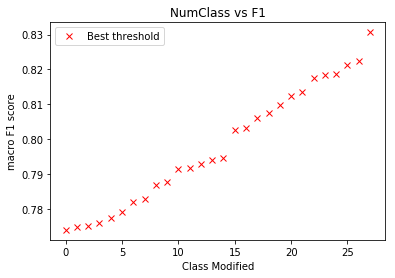

In [6]:
## ensemble models

#class-specific-threshold(i.e. 28 thresholds for each class)
thresholds_candidates = np.linspace(-2, 2, 200)#np.linspace(0.01, 0.99, 50)

thresholds = np.array([0.5]*28)

f1_score_best_list = []

for c in range(28):
    
    f1_scores = []
    for i in thresholds_candidates:
        thresholds[c] = i

        f1_score = macro_f1_numpy(preds_valid, y_valid, threshold=thresholds)
        f1_scores.append(f1_score)

    # best threshold for this class
    threshold_best_index = np.argmax(f1_scores)
    f1_score_best = f1_scores[threshold_best_index]
    threshold_best = thresholds_candidates[threshold_best_index]
    ## add f1_score_best to history, and set threshold best for this class
    f1_score_best_list.append(f1_score_best)
    thresholds[c] = threshold_best

print('Best threshold: ', thresholds)

plt.plot(range(28), f1_score_best_list, "xr", label="Best threshold")
plt.xlabel("Class Modified")
plt.ylabel("macro F1 score")
plt.title("NumClass vs F1")
plt.legend()

In [7]:
preds_valid_label = (preds_valid>thresholds).astype(np.int)
#y_valid = y_valid.astype(np.int)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

i = 0

print(classification_report(y_valid[:, i], preds_valid_label[:, i]))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      3337
          1       0.82      0.89      0.85      1798

avg / total       0.90      0.89      0.89      5135



In [ ]:
# difficult class: 21, 22, 26

## using best threshold to predict

In [7]:
from glob import glob

In [8]:
## ⚠️可能每次读取返回图片（样本）顺序不一样，所以保存的single model prediction可能顺序都不同，不同直接blend
files = glob('data/raw/test/*')
fname_test = list(set([f.replace('_red.png', '').replace('_green.png', '').replace('_blue.png', '').replace('_yellow.png', '').replace('data/raw/test/', '') for f in files]))
len(fname_test)

11702

In [10]:
test_ds = AtlasDataSet(fname_test, mode='test', augmentation=False, IMG_SIZE=IMG_SIZE)
test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )

#TTA
test_ds_flip = AtlasDataSet(fname_test, mode='test', augmentation=False, IMG_SIZE=IMG_SIZE)
test_dl_flip = DataLoader(
        test_ds_flip,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )

IMG_SIZE:  512
IMG_SIZE:  512


In [11]:
%%time
# predict by single model
preds_test = (predict_proba(net, test_dl, device) + predict_proba(net, test_dl_flip, device)) / 2

# saving
with open('prediction/1222_v2_seed3456_tta.pkl', 'wb') as f:
    pickle.dump([preds_test, thresholds, fname_test], f, protocol=4)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 4min 21s, sys: 1min 14s, total: 5min 36s
Wall time: 5min 51s


In [14]:
#loading
# with open('prediction/SEResnet50_512_v1_seed1234.pkl', 'rb') as f:
#     preds_test, thresholds, fname_test = pickle.load(f)

In [166]:
# ## only for ensemble models, do predictions and average probabilities
# ## ⚠️可能每次读取图片（样本）顺序不一样，所以保存的single model prediction可能顺序都不同，不同直接blend

# # load checkpoint and predict
# checkpoint_path = 'checkpoint/1222_v2_seed1234/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test0 = predict_proba(net, test_dl, device)
# print('model 0 done')

# checkpoint_path = 'checkpoint/1222_v2_seed2345/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test1 = predict_proba(net, test_dl, device)
# print('model 1 done')

# checkpoint_path = 'checkpoint/1222_v2_seed3456/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test2 = predict_proba(net, test_dl, device)
# print('model 2 done')

# checkpoint_path = 'checkpoint/1222_v2_seed4567/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test3 = predict_proba(net, test_dl, device)
# print('model 3 done')

# checkpoint_path = 'checkpoint/1222_v2_seed5678/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test4 = predict_proba(net, test_dl, device)
# print('model 4 done')

# preds_test = (preds_test0 + preds_test1 + preds_test2 + preds_test3 + preds_test4) / 5

In [9]:
# # saving
# with open('prediction/1222_v2_blending1234_2345_3456_4567_5678.pkl', 'wb') as f:
#     pickle.dump([preds_test, thresholds, preds_test0, preds_test1, preds_test2, preds_test3, preds_test4, fname_test], 
#                 f, protocol=4)

# saving
with open('prediction/1222_v2_blending1234_2345_3456_tta_thresholds.pkl', 'wb') as f:
    pickle.dump(thresholds, f, protocol=4)

In [83]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [168]:
# load preds for ensemble -- resnet34
with open('prediction/1222_v2_blending1234_2345_3456_4567_5678.pkl', 'rb') as f:
    null_z, null_a, preds_test0, preds_test1, preds_test2, \
    null_b, null_c, fname_test0 = pickle.load(f)
idx = np.argsort(fname_test0)
preds_test0 = preds_test0[idx, :]
preds_test1 = preds_test1[idx, :]
preds_test2 = preds_test2[idx, :]
fname_test = np.array(fname_test0)[idx].tolist()

preds_test = ( preds_test0 + preds_test1 + preds_test2 )#sigmoid

In [32]:
# load preds for ensemble -- resnet34 tta
with open('prediction/1222_v2_seed1234_tta.pkl', 'rb') as f:
    preds_test0, thresholds0, fname_test0 = pickle.load(f)
idx = np.argsort(fname_test0)
preds_test0 = preds_test0[idx, :]
with open('prediction/1222_v2_seed2345_tta.pkl', 'rb') as f:
    preds_test1, thresholds1, fname_test1 = pickle.load(f)
idx = np.argsort(fname_test1)
preds_test1 = preds_test1[idx, :]
with open('prediction/1222_v2_seed3456_tta.pkl', 'rb') as f:
    preds_test2, thresholds2, fname_test2 = pickle.load(f)
idx = np.argsort(fname_test2)
preds_test2 = preds_test2[idx, :]

fname_test = np.array(fname_test2)[idx].tolist()

preds_test = ( preds_test0 + preds_test1 + preds_test2 ) / 3#sigmoid

In [170]:
preds_test = preds_test / 6

In [173]:
# loading
with open('prediction/1222_v2_blending1234_2345_3456_tta_thresholds.pkl', 'rb') as f:
    _, thresholds_ensemble = pickle.load(f)

with open('prediction/1222_v2_seed2345.pkl', 'rb') as f:
    preds_test_single, thresholds_single, fname_test11 = pickle.load(f)
idx = np.argsort(fname_test11)
preds_test_single = preds_test_single[idx, :]

with open('prediction/1222_v2_seed3456.pkl', 'rb') as f:
    _, thresholds_single2 = pickle.load(f)
preds_test_single2 = preds_test2

with open('prediction/1222_v2_seed1234.pkl', 'rb') as f:
    _, thresholds_single3 = pickle.load(f)
preds_test_single3 = preds_test0

In [116]:
# predict class using class-specific-thresholds
preds_test01 = (preds_test > thresholds).astype(np.int) #(preds_test > thresholds_ensemble).astype(np.int)
#preds_test01 = preds01

# predict class using another model, to fillna for the ensemble model
preds_test02 = (preds_test1 > thresholds1).astype(np.int) #(preds_test_single > thresholds_single).astype(np.int)

# predict class using another model, to fillna for the ensemble model
preds_test03 = (preds_test2 > thresholds2).astype(np.int) #(preds_test_single2 > thresholds_single2).astype(np.int)

# predict class using another model, to fillna for the ensemble model
preds_test04 = (preds_test0 > thresholds0).astype(np.int) #(preds_test_single3 > thresholds_single3).astype(np.int)

# predict class using threshold=0.3
#preds_test01 = (torch.sigmoid(torch.from_numpy(preds_test)) > 0.3).numpy().astype(np.int)

In [117]:
## fill na for the ensemble model by single model's prediction for those na images
preds_test01[(preds_test01.sum(axis=1)==0), :] = preds_test02[(preds_test01.sum(axis=1)==0), :]
preds_test01[(preds_test01.sum(axis=1)==0), :] = preds_test03[(preds_test01.sum(axis=1)==0), :]
preds_test01[(preds_test01.sum(axis=1)==0), :] = preds_test04[(preds_test01.sum(axis=1)==0), :]

In [23]:
def encode_2str(arr, fillna=True):
    s = ''
    for i in range(28):
        _s = arr[i]
        if _s==1:
            if s=='':
                s = str(i)
            else:
                s += ' '
                s += str(i)
    if s=='':#sample that predict 0 for all 28 classes
        if fillna:
            s = np.random.choice(['0', '25'], 1)[0]
        else:
            s = '-1'
    return s

In [118]:
output = []
for pred in preds_test01:
    output.append(encode_2str(pred, fillna=True))#False, True

In [119]:
pd.value_counts(output)

0 25             1262
25               1192
0                1191
21                501
23                495
7                 377
5                 278
0 2               256
0 21              251
2                 240
4                 238
11                230
21 25             227
19                205
14                177
6                 172
3                 171
0 7               161
0 21 25           154
0 5               154
1                 123
0 19              111
0 1               110
0 23              103
0 2 25             93
18                 91
2 25               91
12                 84
0 3                82
5 25               69
                 ... 
4 18                1
15 21 25            1
3 12                1
2 13 21 25          1
0 1 19 21           1
7 12                1
14 17 21            1
0 4 23              1
13 14               1
0 4 12              1
23 27               1
0 1 2 4             1
11 13 21            1
4 12 14             1
0 4 22    

In [14]:
# for single model
preds_test01 = (preds_test > thresholds).astype(np.int)
#preds_test01 = (preds_test > 0.4).numpy().astype(np.int)

output = []
for pred in preds_test01:
    output.append(encode_2str(pred, fillna=False))#False, True

In [15]:
pd.value_counts(output)

0 25           1137
25              948
0               839
23              461
21              390
-1              325
7               310
21 25           268
5               257
0 21            227
4               227
0 2             223
0 21 25         206
19              197
2               189
3               175
11              173
0 5             150
0 7             142
6               142
14              136
0 5 25          130
0 19            125
1               113
6 25            111
4 25            104
0 2 25          100
2 25            100
0 23             99
5 25             99
               ... 
21 24 25          1
2 3 7             1
18 21 22          1
4 18 21 25        1
6 16 25           1
0 1 5             1
4 21 22           1
2 21 22           1
1 18              1
4 12              1
0 2 14 16         1
0 13 14           1
12 23 25          1
4 5 14            1
17 18             1
16 17 18 25       1
1 5 7             1
3 25 26           1
0 2 6             1


## submit

In [120]:
sub = pd.DataFrame({'Id': fname_test, 'Predicted':output}, columns=['Id', 'Predicted'])
sub.sort_values(by=['Id'], inplace=True)
sub.reset_index(drop=True, inplace=True)

In [121]:
sub.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25


In [42]:
#print(sub_name)
sub.to_csv('submissions/SE_RESNET50_512_v1_seed2345_threshold0.4.csv.gz', compression='gzip', index=False)

In [50]:
#sub.Predicted.value_counts()

In [124]:
sub_best = pd.read_csv('submissions/581_blending_seed1234_2345_3456_fillna_seed1234_2345_3456_with_leak259_tta.csv.gz', compression='gzip')
sub_check = sub.merge(sub_best, on=['Id']).rename(columns={'Predicted_x':'sub', 'Predicted_y':'old_sub'})
sub_check

,Id,sub,old_sub
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25,25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,4 25,4 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0,0 25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,4 25,4 25


In [125]:
(sub_check['sub']==sub_check['old_sub']).mean()

0.8197743975388823

## is there leak images?

In [48]:
import pandas as pd
import numpy as np

In [126]:
leak = pd.read_csv('data/raw/leak/TestEtraMatchingUnder_259_R14_G12_B10.csv')
external_data = pd.read_csv('data/raw/external_data.csv')

In [127]:
leak['Extra'] = ['_'.join(fname.split('_')[1:]) for fname in leak.Extra]

In [128]:
leak = leak[['Extra', 'Test']].drop_duplicates('Test')
leak.head(2)

,Extra,Test
0,44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0
1,35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0


In [129]:
external_data = external_data.rename(columns={'Id': 'Extra'})
external_data.head(2)

,Extra,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21


In [130]:
leak = leak.merge(external_data, on=['Extra'], how='left')[['Test', 'Target']]

In [131]:
leak.head(2)

,Test,Target
0,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,25 18 0
1,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,25 17 0


In [79]:
# best LB by model
#sub = pd.read_csv('submissions/blend_f1loss_seed1234_n_old_loss_seed123456.csv.gz')
#sub.head(2)

In [132]:
cnt = 0
for i in leak.index:
    fname = leak.loc[i, 'Test']
    leak_target = leak.loc[i, 'Target']
    pred_target = sub.loc[sub.Id==fname, 'Predicted'].values[0]
    if sorted(leak_target.split(' ')) != sorted(pred_target.split(' ')):
        print(sorted(leak_target.split(' ')), ' vs ', sorted(pred_target.split(' ')))
        sub.loc[sub.Id==fname, 'Predicted'] = leak_target
        cnt += 1
cnt

['2', '23']  vs  ['25']
['0', '21', '23']  vs  ['0', '21', '25']
['0', '14']  vs  ['0', '14', '25']
['0']  vs  ['0', '16']
['21']  vs  ['0', '21']
['1', '2']  vs  ['2']
['12', '13']  vs  ['13']
['2', '21', '26', '4']  vs  ['2', '26', '4']
['14', '16', '25']  vs  ['16', '25']
['0', '21', '22']  vs  ['21', '7']
['25']  vs  ['16', '25']
['13']  vs  ['0']
['13']  vs  ['0', '25', '5']
['21', '25']  vs  ['25', '7']
['2', '22']  vs  ['0', '22']
['21', '4']  vs  ['4']
['21', '4']  vs  ['4']
['2']  vs  ['7']
['11', '2']  vs  ['0', '11', '2']
['0', '19']  vs  ['18', '19']
['12', '21', '25']  vs  ['12', '25']
['0', '14']  vs  ['14']
['1', '5']  vs  ['1']
['0']  vs  ['0', '25']
['21']  vs  ['0', '21']
['0']  vs  ['0', '16']
['14', '25']  vs  ['0', '14']
['14']  vs  ['0', '14']
['14']  vs  ['0', '14']
['25']  vs  ['21', '22', '25']
['1', '4']  vs  ['0', '1', '25']
['0', '25', '5']  vs  ['0', '5']
['25']  vs  ['14', '16', '25']
['27']  vs  ['23']
['27']  vs  ['0', '27']
['25']  vs  ['21', '25']
['2'

128

In [78]:
#sub2 = sub.copy()

In [77]:
#(sub2.Predicted!=sub.Predicted).sum()

In [133]:
sub.to_csv('submissions/voting_blend_20models.csv.gz', compression='gzip', index=False)

In [80]:
145/len(sub2.index)

0.012391044265937446

## try some voting

In [67]:
subs = \
['submissions/512_SE_RESNET50_512_v1_seed2345_threshold0.4.csv.gz',
 'submissions/537_SE_RESNET50_512_v1_seed1234_threshold0.4.csv.gz',
 'submissions/515_RESNET34_512_v1_seed1234_f1_loss.csv.gz',
 'submissions/583_blending_seed1234_2345_3456_fillna_seed1234_2345_3456_with_leak259.csv.gz',
 'submissions/557_blending_SEResnet_seed1234_2345_3456_with_leak259.csv.gz',
 'submissions/538_1222_v2_seed3456.csv.gz',
 'submissions/574_blending_resnet34_SEResnet_seed1234_2345_3456_with_leak259.csv.gz',
 'submissions/507_init_v2_seed1234.csv.gz',
 'submissions/565_1222_v2_blending_1234_2345_3456_4567_5678.csv.gz',
 'submissions/456_RESNET34_256_v2_seed1234.csv.gz',
 'submissions/559_blending_RESNET34_seed1234_2345_3456_RESNET18_seed1234.csv.gz',
 'submissions/528_1222_v2_seed4567.csv.gz',
 'submissions/526_SE_RESNET50_512_v2_seed1234_threshold0.4.csv.gz',
 'submissions/581_blending_seed1234_2345_3456_fillna_seed1234_2345_3456_with_leak259_tta.csv.gz',
 'submissions/522_1222_v2_seed1234.csv.gz',
 'submissions/577_blending_seed1234_2345_3456_fillna_seed2345.csv.gz',
 'submissions/529_RESNET34_512_v2_seed1234_full_HPAdata.csv.gz',
 'submissions/576_1222_v2_blend1234_2345_3456.csv.gz',
 'submissions/544_1222_v2_seed2345.csv.gz',
 'submissions/582_blending_seed1234_2345_3456_fillna_seed2345_with_leak259.csv.gz']

In [111]:
from dataset import multi_hot

def do_multi_hot(sub):
    target_list = []
    for i in sub.index:
        target = multi_hot(sub.loc[i, 'Predicted'])
        target_list.append(target)
    target_arr = np.array(target_list)
    return target_arr


preds = None
print(len(subs))
for _f in subs:
    _sub = pd.read_csv(_f)
    target_arr = do_multi_hot(_sub)
    if preds is None:
        preds = target_arr
    else:
        preds += target_arr

20


In [112]:
preds

array([[ 0,  0, 20, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  6,  0,  0],
       [20,  0,  0, ..., 20,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  0],
       [13, 20,  0, ...,  0,  0,  0],
       [20,  0,  0, ..., 18,  0,  0]])

In [113]:
# for single model
preds01 = (preds > 10).astype(np.int)

output = []
for pred in preds01:
    output.append(encode_2str(pred, fillna=False))#False, True

In [114]:
pd.value_counts(output)

0 25             1260
0                1169
25               1131
21                475
23                463
-1                366
7                 359
0 2               255
5                 253
0 21              250
2                 234
4                 227
11                223
21 25             223
19                186
14                172
6                 168
3                 165
0 7               161
0 21 25           154
0 5               154
1                 122
0 19              111
0 1               109
0 23              103
0 2 25             93
2 25               90
0 3                82
18                 80
12                 78
                 ... 
0 20 23             1
0 4 14 16           1
0 2 13 25           1
2 3 23 25           1
0 17 22             1
14 17 23            1
2 13 21 25          1
0 1 19 21           1
7 12                1
14 17 21            1
0 4 23              1
13 14               1
0 4 12              1
23 27               1
0 1 2 4   